In [1]:
import os;
os.getcwd()

'/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting'

In [2]:
import pandas as pd
from tqdm import tqdm
import sys
from datetime import datetime
import pytz
#padas market clandar open_at_time function
import pandas_market_calendars as mcal
# custom imports from this repo
sys.path.append("../Financial Data Structures")
from utils.read_data import read_ticks

In [3]:
cal = mcal.get_calendar("CME_Equity")
sched = cal.schedule(start_date="2023-01-01", end_date="2024-12-31")

In [82]:
ticks = "/Users/dan/Documents/Finance/Historical Data/ES-Futures-Ticks-20230807-20240806.trades.filtered.csv"

skipped_closed = 0
skipped_weekend = 0
skipped_am = 0
skipped_pm = 0

data = {"time": [], "price": [], "volume": [], "symbol": []}
with open(ticks, "r") as f:
    for i, line in enumerate(tqdm(f)):
        if i == 0:
            continue
        line = line.strip().split(",")
        if line[3] != "ESH4":
            continue
        if not cal.open_at_time(sched, line[0]):
            skipped_closed += 1
            continue
        dt = datetime.fromisoformat(line[0]).astimezone(pytz.timezone("US/Eastern"))
        if dt.weekday() > 4:
            skipped_weekend += 1
            continue
        if dt.hour < 9 or (dt.hour == 9 and dt.minute < 30):
            skipped_am += 1
            continue
        if dt.hour > 16 or (dt.hour == 16 and dt.minute > 30):
            skipped_pm += 1
            continue
        time = dt.timestamp() 
        data["time"].append(time)
        data["price"].append(float(line[1]))
        data["volume"].append(float(line[2]))
        data["symbol"].append(line[3])

print(f"{skipped_closed=}, {skipped_weekend=}, {skipped_am=}, {skipped_pm=}, {len(data['time'])=}")

82971691it [3:19:16, 6939.67it/s]   

skipped_closed=86649, skipped_weekend=152658, skipped_am=3175508, skipped_pm=692987, len(data['time'])=16381749


In [ ]:
"""
skipped_closed=86649, skipped_weekend=40711, skipped_am=1499093, skipped_pm=9679328, skipped_sampling=9183769
9183770
"""

In [83]:
df = pd.DataFrame(data)
df.to_csv("ES-Trades-During-Market-Hours.csv", index=False)

In [84]:
len(df)

16381749

In [12]:
df = pd.DataFrame(data)
len(df)

9183770

<Axes: >

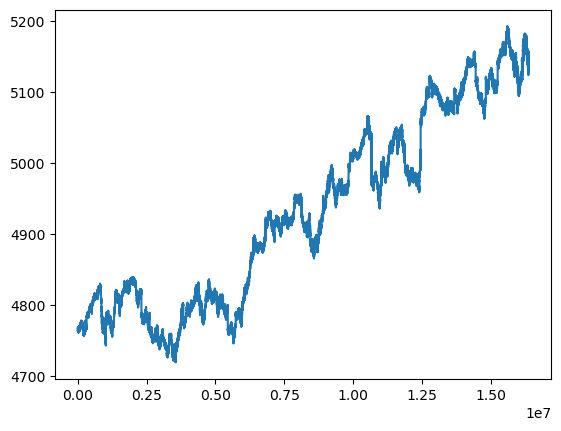

In [85]:
df['price'].plot()

<Axes: >

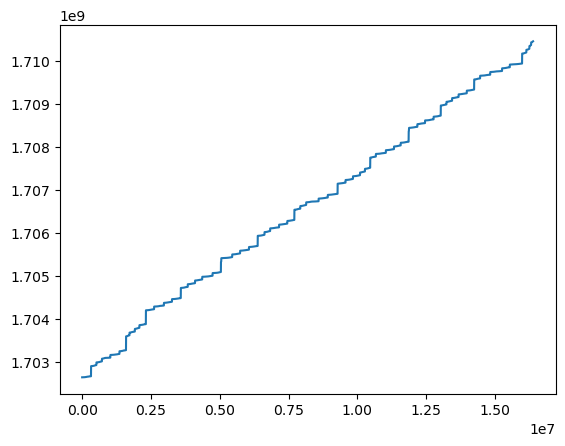

In [86]:
df['time'].plot()

In [87]:
# the time column contains time in isoformat, convert to datetime in EST
tqdm.pandas()
# df["time"] = df["time"].apply(lambda x: datetime.fromtimestamp(x, pytz.timezone("US/Eastern")))
df["time"] = df["time"].progress_apply(lambda x: datetime.fromtimestamp(x, pytz.timezone("US/Eastern")))


100%|██████████| 16381749/16381749 [01:05<00:00, 249738.49it/s]


In [89]:
#convert the df time column to a datetime in EST
df

,time,price,volume,symbol
0,2023-12-15 09:30:00.000526-05:00,4768.25,16.0,ESH4
1,2023-12-15 09:30:00.000938-05:00,4768.25,3.0,ESH4
2,2023-12-15 09:30:00.000980-05:00,4768.25,1.0,ESH4
3,2023-12-15 09:30:00.000981-05:00,4768.25,2.0,ESH4
4,2023-12-15 09:30:00.000981-05:00,4768.25,2.0,ESH4
...,...,...,...,...
16381744,2024-03-14 16:30:51.592317-04:00,5154.25,1.0,ESH4
16381745,2024-03-14 16:30:52.478797-04:00,5154.25,1.0,ESH4
16381746,2024-03-14 16:30:53.238443-04:00,5154.25,3.0,ESH4
16381747,2024-03-14 16:30:53.865967-04:00,5154.50,3.0,ESH4


In [29]:
# get average number of trades per second
# our data goes to milliseconds, count how many rows within the same second
current_second = df["time"].iloc[0].second
number_of_trades_in_current_second = 0
number_of_trades_per_second = []
for i in tqdm(range(len(df))):
    if df["time"].iloc[i].second == current_second:
        number_of_trades_in_current_second += 1        
    else:
        number_of_trades_per_second.append(number_of_trades_in_current_second)
        number_of_trades_in_current_second = 1
        current_second = df["time"].iloc[i].second



100%|██████████| 9183770/9183770 [00:51<00:00, 179231.01it/s]


In [90]:
import numpy as np
np.mean(number_of_trades_per_second)

10.536352215689087

10.536365367715051 903 1


(0.0, 75.0)

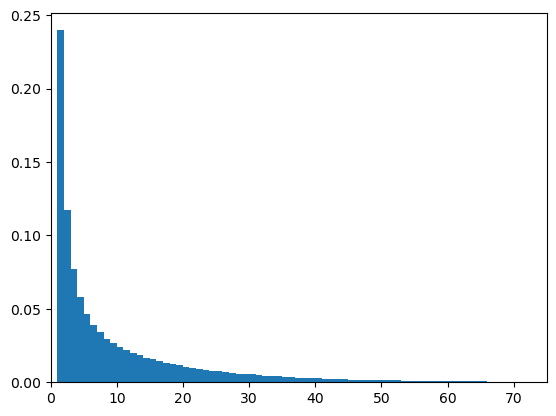

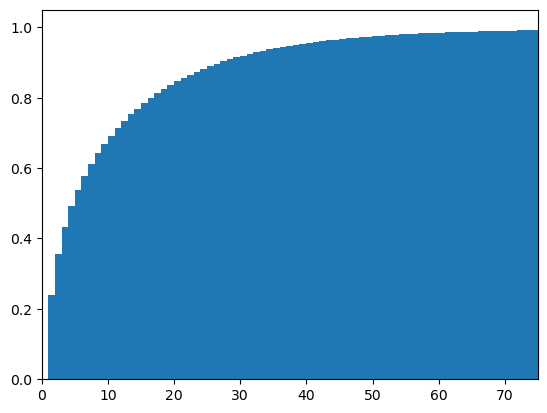

In [53]:
x= df['time'].dt.floor('s').value_counts()
print(x.mean(), x.max(), x.min())

#histogram of trades per second
import matplotlib.pyplot as plt
# plt.hist(number_of_trades_per_second, bins=100)
# plt.xlim(0, 100)
# we want the y axis to give the proportion of trades in each bin
plt.hist(number_of_trades_per_second, bins=903, density=True)
plt.xlim(0, 75)
# draw a cumulative distribution function
plt.figure()
plt.hist(number_of_trades_per_second, bins=903, density=True, cumulative=True)
plt.xlim(0, 75)


<Axes: xlabel='day_of_week'>

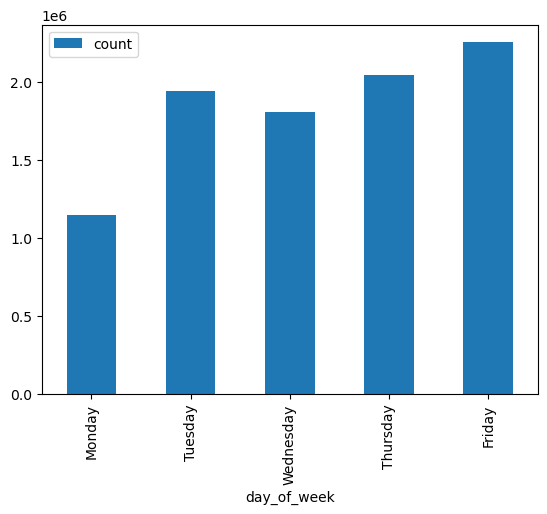

In [67]:
# now lets compute trades per day of the week
df["day_of_week"] = df["time"].dt.day_name()
df["day_of_week"].value_counts().to_frame().T[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]].T.plot(kind="bar")

####

In [70]:
# lets do the same analysis for trades per hour of the day
df["hour"] = df["time"].dt.hour
df["hour"].value_counts().sort_index().to_frame()

,count
hour,
4,125445
5,222476
6,250123
7,311131
8,866187
9,2853279
10,3236759
11,1298549
12,19821


In [80]:
df[100000:140000]

,time,price,volume,symbol,day_of_week,hour
100000,2023-12-15 10:29:21.724380-05:00,4774.0,6.0,ESH4,Friday,10
100001,2023-12-15 10:29:21.724483-05:00,4774.0,1.0,ESH4,Friday,10
100002,2023-12-15 10:29:21.725142-05:00,4774.0,1.0,ESH4,Friday,10
100003,2023-12-15 10:29:21.795886-05:00,4774.0,1.0,ESH4,Friday,10
100004,2023-12-15 10:29:21.971661-05:00,4774.0,12.0,ESH4,Friday,10
...,...,...,...,...,...,...
139995,2023-12-18 04:53:37.023125-05:00,4779.5,2.0,ESH4,Monday,4
139996,2023-12-18 04:53:37.023354-05:00,4779.5,2.0,ESH4,Monday,4
139997,2023-12-18 04:53:37.037636-05:00,4779.5,3.0,ESH4,Monday,4
139998,2023-12-18 04:53:37.038546-05:00,4779.5,1.0,ESH4,Monday,4


### When there are trades, on average there are 10 trades per second. At most, there are 903 trades in one second. That means one trade every 1.1 milliseconds. An HFT system will need to act within 1 millisecond if it is to have the pick of the market.

### Most of the trades happen on Fridays

In [ ]:
# Todo: Apply 1 tick of slippage to each trade

from collections import deque
import numpy as np

window = 600
prices = deque(maxlen=window)
upper_band = 0
lower_band = 0
mu = 0
std = 0
qty = 0
open_price = 0
current_profit = 0
total_profit = 0
commission = 2.25
leverage = 50
trade_cost = commission * 2 / leverage


buys = []
sells = []
holding_periods = []

last_price = data['price'][0]

for i in tqdm(range(len(data['time']))):
    slip_price = last_price
    last_price = data['price'][i]
    prices.append(last_price)
    if len(prices) < window:
        continue

    mu = np.mean(prices)
    std = np.std(prices)

    upper_band = mu + 2 * std
    lower_band = mu - 2 * std

    if qty == 1:
        current_profit = (last_price - open_price) * leverage - trade_cost
    elif qty == -1:
        current_profit = (open_price - last_price) * leverage - trade_cost

    if qty == 0: 
        if last_price < lower_band - trade_cost:
            open_price = last_price
            qty = 1
            mean_side = "under"
            buys.append(i)

        elif last_price > upper_band + trade_cost:
            open_price = last_price
            qty = -1
            mean_side = "over"
            sells.append(i)

    elif qty == 1:
        if last_price >= mu and mean_side == "under":
            open_price = last_price
            qty = 0
            mean_side = "over"
            total_profit += current_profit
            sells.append(i)
            holding_periods.append(sells[-1] - buys[-1])

    elif qty == -1:
        if last_price <= mu and mean_side == "over":
            open_price = last_price
            qty = 0
            mean_side = "under"
            total_profit += current_profit
            buys.append(i)
            holding_periods.append(buys[-1] - sells[-1])


f"{total_profit=}\n{np.mean(holding_periods)=}"




##### When there are trades, on average there are 10 trades per second. At most, there are 

In [ ]:
# plot the prices with markers for buys and sells
import matplotlib.pyplot as plt
plt.plot(data['price'])
plt.scatter(buys, [data['price'][i] for i in buys], color='green', marker='triangle_up')
plt.scatter(sells, [data['price'][i] for i in sells], color='red', marker='triangle_down')
plt.show()